In [132]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display   #for loading and visualizing audio files
import IPython.display as ipd   #to play audio

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import time 
import pickle

# PCA

In [25]:
from sklearn.decomposition import PCA

Create function:
1. Which takes the numpy arrays containing y for each track_id. 
2. calculate DB for each track_id
3. ravel each DB into a numpy array
4. Once collected all, PCA into certain number of components.
5. Collect PCA components in dataframe and model on this

In [ ]:
df_PCA = pd.DataFrame(pca.transform(demo_noage), columns=[f'PC_{i+1}' for i in range(pca.n_components_)])
demo_pcs

In [89]:
a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/050993.npy', "rb")
ATS_050993 = np.load(a_array)

In [90]:
ATS_050993.shape

(661248,)

In [91]:
DB = librosa.amplitude_to_db(np.abs(librosa.stft(y = ATS_050993)), ref=np.max) #extracting DB
DB_ravel = DB.ravel()

In [94]:
DB_ravel.shape

(1324300,)

In [176]:
ATS_0_50_fp = '/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50'
ATS_0_50 = os.listdir(ATS_0_50_fp)
ATS_0_50

['000139.npy',
 '000140.npy',
 '000141.npy',
 '000148.npy',
 '000181.npy',
 '000182.npy',
 '000190.npy',
 '000193.npy',
 '000194.npy',
 '000197.npy',
 '000198.npy',
 '000200.npy',
 '000203.npy',
 '000204.npy',
 '000207.npy',
 '000208.npy',
 '000209.npy',
 '000210.npy',
 '000211.npy',
 '000212.npy',
 '000213.npy',
 '000237.npy',
 '000247.npy',
 '000249.npy',
 '000255.npy',
 '000256.npy',
 '000257.npy',
 '000258.npy',
 '000341.npy',
 '000343.npy',
 '000352.npy',
 '000368.npy',
 '000369.npy',
 '000397.npy',
 '000398.npy',
 '000399.npy',
 '000136.npy',
 '000400.npy',
 '000405.npy',
 '000414.npy',
 '000424.npy',
 '000425.npy',
 '000458.npy',
 '000459.npy',
 '000512.npy',
 '000534.npy',
 '000535.npy',
 '000536.npy',
 '000537.npy',
 '000540.npy',
 '000546.npy',
 '000550.npy',
 '000564.npy',
 '000573.npy',
 '000574.npy',
 '000583.npy',
 '000584.npy',
 '000585.npy',
 '000590.npy',
 '000591.npy',
 '000592.npy',
 '000593.npy',
 '000602.npy',
 '000603.npy',
 '000605.npy',
 '000002.npy',
 '000003.n

In [149]:
track_id_list = []
stacked_array_list = []

DB_stacked = np.zeros(1324300)

for i, val in enumerate(ATS_0_50[0:10]):
    a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/{}'.format(val), "rb")
    ATS = np.load(a_array)
    ATS.resize((661500,),refcheck=False) #resizing ATS to be 661500
    DB = librosa.amplitude_to_db(np.abs(librosa.stft(y=ATS)), ref=np.max) #extracting DB
    DB_ravel = DB.ravel() #flattening DB

    track_id_list.append(val.split('.')[0])
    if i == 0:
        DB_stacked = DB_ravel
    else:
        DB_stacked = np.vstack((DB_stacked, DB_ravel))
        
    print(DB_stacked.shape)
    print("__________")
    
#track_id_list
np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked)

(1324300,)
__________
(2, 1324300)
__________
(3, 1324300)
__________
(4, 1324300)
__________
(5, 1324300)
__________
(6, 1324300)
__________
(7, 1324300)
__________
(8, 1324300)
__________
(9, 1324300)
__________
(10, 1324300)
__________


In [246]:
DB_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', "rb")
DB_stacked_0_50 = np.load(DB_fp)

In [250]:
DB_stacked_0_50

array([-80.      , -70.33023 , -62.184227, ..., -80.      , -80.      ,
       -80.      ], dtype=float32)

Use cleaned dataframe from method 1 to only stack non-duplicated track_id's and corresponding ATS. Also avoiding tracks that have been tagged with erroneous genres. 

Use df_classifier_0_100_spark.csv to reference extraction

In [4]:
df_classifier1_0_100 = pd.read_csv('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/final_dfs/df_classifier1_0_100_trim.csv',dtype = {'track_id':str, 'folder':str}, index_col=False) #loading csv
df_classifier1_0_100.drop(axis = 1, columns=['Unnamed: 0','level_0','index'],inplace =True)

In [199]:
df_classifier1_0_100.folder.unique()[0:51]

array(['000', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '040', '041', '042', '043', '044',
       '045', '046', '047', '048', '049', '050'], dtype=object)

In [200]:
df_ref = df_classifier1_0_100[['track_id','folder','genres_top','genres','genres_all']]

In [12]:
condition_0_50 = df_classifier1_0_100.folder.isin(df_classifier1_0_100.folder.unique()[0:51])

In [19]:
df_classifier1_0_100.genres_top.value_counts()

Rock            4483
Electronic      4343
Experimental    1448
Hip-Hop         1373
Folk             923
Pop              725
Classical        505
Instrumental     363
Jazz             343
Soul-RnB         113
Country          108
Blues             55
Name: genres_top, dtype: int64

In [34]:
115*11 + 55 

1320

In [16]:
df_classifier1_0_100[condition_0_50].genres_top.value_counts()

Rock            2268
Electronic      1933
Experimental     800
Hip-Hop          543
Folk             469
Pop              354
Classical        259
Jazz             200
Instrumental     141
Country           81
Soul-RnB          68
Blues             48
Name: genres_top, dtype: int64

Expect shape of ( < 1500, 1324300) from final DB_stacked_0_50

As stacking ATS numpyarrays will require a lot of RAM cannot stack all tracks and PCA on this need to select a partition of the data. Cannot randomly select otherwise will have major class imbalance with an already low amount of rows per genre (since only a partition).

Only extracting genres up until number of tracks with a certain genre reaches minimum quota. Continues collecting other track_ids with other genres until quota reached for given genre and so on. 

***EXTRACTING*** 

Getting DB stacked numpy array for track_ids in folders 0 - 50 and saving to hard drive (*Do not run twice*)

In [172]:
def check_genre(genre, ID):
    return df_ref[condition]['genres_top'].values[0] == genre
ID = '000002'
check_genre('Hip-Hop',ID)

In [210]:
ATS_0_50_fp = '/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50'
ATS_0_50 = os.listdir(ATS_0_50_fp)

track_id_list = []
track_id_notadded = []

DB_stacked = np.zeros(1324300)
count = 0
genre_list = ['Rock', 'Electronic', 'Experimental', 'Hip-Hop', 'Folk', 'Pop', 'Classical', 'Jazz', 'Instrumental', 
              'Country', 'Soul-RnB', 'Blues']
# ______ 
rock = 0
elec = 0
exp = 0
HH = 0
folk = 0
pop = 0
classical = 0
jazz = 0
instr = 0
country = 0
soul = 0
blues =0 
# ______

for i, val in enumerate(ATS_0_50):
    a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/{}'.format(val), "rb")
    ATS = np.load(a_array)
    ATS.resize((661500,),refcheck=False)     #resizing ATS to be 661500
    DB = librosa.amplitude_to_db(np.abs(librosa.stft(y = ATS)), ref=np.max) #extracting DB
    DB_ravel = DB.ravel()     #flattening DB
    ID = str(val.split('.')[0])
    target = 115
    if ID in df_ref.track_id.values:
        condition = df_ref.track_id == ID
        if i == 0:
            DB_stacked = DB_ravel
            track_id_list.append(val.split('.')[0])            
        elif check_genre('Rock',ID) & (rock < target):
            rock = rock + 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Rock :', df_ref[condition].genres_top.values[0])
        elif check_genre('Electronic',ID) & (elec < target):
            elec += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Electronic :', df_ref[condition].genres_top.values[0])
        elif check_genre('Experimental',ID) & (exp < target):
            exp += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Experimental :', df_ref[condition].genres_top.values[0])
        elif check_genre('Hip-Hop',ID) & (HH < target):
            HH += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Hip-Hop :', df_ref[condition].genres_top.values[0])
        elif check_genre('Folk',ID) & (folk < target):
            folk += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))   
            #print('Folk :', df_ref[condition].genres_top.values[0])
        elif check_genre('Pop',ID) & (pop < target):
            pop += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Pop :', df_ref[condition].genres_top.values[0])
        elif check_genre('Classical',ID) & (classical < target):
            classical += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Classical :', df_ref[condition].genres_top.values[0])
        elif check_genre('Jazz',ID) & (jazz < target):
            jazz += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Jazz :', df_ref[condition].genres_top.values[0])
        elif check_genre('Instrumental',ID) & (instr < target):
            instr += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Instrumental :', df_ref[condition].genres_top.values[0])
        elif check_genre('Country',ID) & (country < target):
            country += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Country :', df_ref[condition].genres_top.values[0])
        elif check_genre('Soul-RnB',ID) & (soul < target):
            soul += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel)) 
            #print('Soul-RnB :', df_ref[condition].genres_top.values[0])
        elif check_genre('Blues',ID) & (blues < target):
            blues += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Blues :', df_ref[condition].genres_top.values[0])
        else:
            print("NONE :",df_ref[condition].genres_top.values[0])
            track_id_notadded.append(ID)
        print('track_id :', ID)
    else:
        pass
    count = count + 1
    print(i)
    if count == 100:
        np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked) 
        count = 0
np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked)

track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "wb")
pickle.dump(track_id_list, track_id_fp)
track_id_fp.close()
#track_id_list.insert(0,'000139')

track_id : 000139
0
track_id : 000140
1
track_id : 000141
2
track_id : 000148
3
track_id : 000181
4
track_id : 000182
5
track_id : 000190
6
track_id : 000193
7
track_id : 000194
8
track_id : 000197
9
track_id : 000198
10
track_id : 000200
11
track_id : 000203
12
track_id : 000204
13
track_id : 000207
14
track_id : 000208
15
track_id : 000209
16
track_id : 000210
17
track_id : 000211
18
track_id : 000212
19
track_id : 000213
20
track_id : 000237
21
track_id : 000247
22
track_id : 000249
23
track_id : 000255
24
track_id : 000256
25
track_id : 000257
26
track_id : 000258
27
track_id : 000341
28
track_id : 000343
29
track_id : 000352
30
track_id : 000368
31
track_id : 000369
32
track_id : 000397
33
track_id : 000398
34
track_id : 000399
35
track_id : 000136
36
track_id : 000400
37
track_id : 000405
38
track_id : 000414
39
track_id : 000424
40
track_id : 000425
41
track_id : 000458
42
track_id : 000459
43
track_id : 000512
44
track_id : 000534
45
track_id : 000535
46
track_id : 000536
47
tr

NONE : Rock
track_id : 001891
390
track_id : 001893
391
track_id : 001894
392
track_id : 001896
393
NONE : Rock
track_id : 001898
394
NONE : Rock
track_id : 001899
395
NONE : Rock
track_id : 001900
396
NONE : Rock
track_id : 001901
397
track_id : 001916
398
track_id : 001924
399
track_id : 001925
400
track_id : 001926
401
track_id : 001929
402
NONE : Rock
track_id : 001930
403
NONE : Rock
track_id : 001940
404
NONE : Rock
track_id : 001941
405
NONE : Rock
track_id : 001944
406
track_id : 001963
407
track_id : 001964
408
track_id : 001965
409
track_id : 001966
410
track_id : 001967
411
NONE : Rock
track_id : 001995
412
track_id : 001996
413
track_id : 002012
414
track_id : 002096
415
track_id : 002097
416
track_id : 002099
417
NONE : Rock
track_id : 002125
418
track_id : 003263
419
track_id : 003264
420
track_id : 003265
421
track_id : 003266
422
track_id : 003268
423
track_id : 003270
424
track_id : 003271
425
track_id : 003272
426
track_id : 003273
427
track_id : 003274
428
NONE : Roc

NONE : Rock
track_id : 004216
694
NONE : Rock
track_id : 004217
695
NONE : Rock
track_id : 004218
696
NONE : Rock
track_id : 004219
697
698
699
700
701
702
703
NONE : Rock
track_id : 004264
704
NONE : Rock
track_id : 004267
705
NONE : Rock
track_id : 004275
706
NONE : Rock
track_id : 004276
707
NONE : Rock
track_id : 004284
708
NONE : Rock
track_id : 004285
709
NONE : Rock
track_id : 004297
710
NONE : Rock
track_id : 004298
711
NONE : Rock
track_id : 004299
712
NONE : Rock
track_id : 004300
713
NONE : Rock
track_id : 004302
714
NONE : Rock
track_id : 004309
715
NONE : Rock
track_id : 004310
716
NONE : Rock
track_id : 004311
717
NONE : Rock
track_id : 004312
718
NONE : Rock
track_id : 004313
719
NONE : Rock
track_id : 004316
720
NONE : Rock
track_id : 004330
721
NONE : Rock
track_id : 004332
722
NONE : Rock
track_id : 004333
723
NONE : Rock
track_id : 004346
724
NONE : Rock
track_id : 004348
725
NONE : Rock
track_id : 004363
726
NONE : Rock
track_id : 004368
727
NONE : Rock
track_id : 0

NONE : Rock
track_id : 006520
1035
NONE : Rock
track_id : 006522
1036
1037
NONE : Rock
track_id : 006524
1038
NONE : Rock
track_id : 006525
1039
NONE : Rock
track_id : 006527
1040
NONE : Rock
track_id : 006528
1041
NONE : Rock
track_id : 006529
1042
NONE : Rock
track_id : 006530
1043
NONE : Rock
track_id : 006532
1044
NONE : Rock
track_id : 006533
1045
NONE : Rock
track_id : 006534
1046
NONE : Rock
track_id : 006536
1047
NONE : Rock
track_id : 006537
1048
1049
1050
NONE : Rock
track_id : 006593
1051
NONE : Rock
track_id : 006595
1052
NONE : Rock
track_id : 006596
1053
NONE : Rock
track_id : 006597
1054
NONE : Rock
track_id : 006598
1055
NONE : Rock
track_id : 006600
1056
NONE : Rock
track_id : 006602
1057
track_id : 006603
1058
track_id : 006605
1059
track_id : 006606
1060
track_id : 006607
1061
track_id : 006608
1062
track_id : 006609
1063
track_id : 006610
1064
track_id : 006611
1065
NONE : Rock
track_id : 006627
1066
NONE : Rock
track_id : 006630
1067
NONE : Rock
track_id : 006631
1

NONE : Rock
track_id : 008453
1308
NONE : Rock
track_id : 008454
1309
NONE : Rock
track_id : 008455
1310
NONE : Rock
track_id : 008489
1311
NONE : Rock
track_id : 008490
1312
NONE : Rock
track_id : 008491
1313
NONE : Rock
track_id : 008494
1314
NONE : Rock
track_id : 008497
1315
NONE : Rock
track_id : 008514
1316
NONE : Rock
track_id : 008531
1317
NONE : Rock
track_id : 008575
1318
NONE : Rock
track_id : 008576
1319
NONE : Rock
track_id : 008578
1320
track_id : 008580
1321
track_id : 008582
1322
track_id : 008584
1323
NONE : Rock
track_id : 008914
1324
NONE : Rock
track_id : 008917
1325
NONE : Rock
track_id : 008920
1326
NONE : Rock
track_id : 008921
1327
NONE : Rock
track_id : 008922
1328
track_id : 009152
1329
track_id : 009155
1330
NONE : Rock
track_id : 009188
1331
track_id : 009307
1332
track_id : 009476
1333
track_id : 009477
1334
track_id : 009490
1335
NONE : Rock
track_id : 009491
1336
NONE : Rock
track_id : 009492
1337
NONE : Rock
track_id : 009493
1338
track_id : 009505
1339


track_id : 010666
1572
NONE : Rock
track_id : 010668
1573
NONE : Rock
track_id : 010669
1574
NONE : Rock
track_id : 010670
1575
NONE : Rock
track_id : 010671
1576
NONE : Rock
track_id : 010672
1577
NONE : Rock
track_id : 010673
1578
NONE : Rock
track_id : 010674
1579
NONE : Rock
track_id : 010675
1580
NONE : Rock
track_id : 010676
1581
NONE : Rock
track_id : 010677
1582
NONE : Folk
track_id : 010678
1583
NONE : Folk
track_id : 010679
1584
NONE : Folk
track_id : 010680
1585
NONE : Folk
track_id : 010681
1586
NONE : Folk
track_id : 010682
1587
NONE : Folk
track_id : 010683
1588
NONE : Folk
track_id : 010684
1589
NONE : Folk
track_id : 010685
1590
NONE : Folk
track_id : 010686
1591
track_id : 010689
1592
track_id : 010690
1593
track_id : 010692
1594
track_id : 010693
1595
track_id : 010694
1596
track_id : 010695
1597
track_id : 010696
1598
track_id : 010697
1599
track_id : 010698
1600
track_id : 010699
1601
NONE : Electronic
track_id : 010728
1602
track_id : 010737
1603
track_id : 010739


NONE : Hip-Hop
track_id : 011858
1858
NONE : Hip-Hop
track_id : 011859
1859
NONE : Hip-Hop
track_id : 011861
1860
NONE : Hip-Hop
track_id : 011862
1861
NONE : Hip-Hop
track_id : 011863
1862
NONE : Hip-Hop
track_id : 011864
1863
NONE : Hip-Hop
track_id : 011865
1864
NONE : Hip-Hop
track_id : 011866
1865
NONE : Hip-Hop
track_id : 011867
1866
NONE : Hip-Hop
track_id : 011868
1867
NONE : Hip-Hop
track_id : 011869
1868
NONE : Hip-Hop
track_id : 011875
1869
NONE : Hip-Hop
track_id : 011879
1870
NONE : Hip-Hop
track_id : 011880
1871
NONE : Hip-Hop
track_id : 011881
1872
NONE : Hip-Hop
track_id : 011882
1873
NONE : Hip-Hop
track_id : 011883
1874
NONE : Hip-Hop
track_id : 011884
1875
NONE : Hip-Hop
track_id : 011885
1876
NONE : Hip-Hop
track_id : 011886
1877
NONE : Hip-Hop
track_id : 011888
1878
NONE : Hip-Hop
track_id : 011889
1879
NONE : Hip-Hop
track_id : 011890
1880
NONE : Hip-Hop
track_id : 011891
1881
NONE : Hip-Hop
track_id : 011892
1882
NONE : Hip-Hop
track_id : 011893
1883
NONE : Hip-H

track_id : 012673
2092
track_id : 012674
2093
track_id : 012675
2094
track_id : 012676
2095
track_id : 012677
2096
2097
2098
2099
NONE : Experimental
track_id : 012737
2100
NONE : Experimental
track_id : 012744
2101
NONE : Experimental
track_id : 012833
2102
NONE : Experimental
track_id : 012835
2103
NONE : Experimental
track_id : 012836
2104
track_id : 012922
2105
track_id : 012923
2106
track_id : 012924
2107
track_id : 012926
2108
track_id : 012927
2109
NONE : Folk
track_id : 012985
2110
NONE : Folk
track_id : 012986
2111
NONE : Electronic
track_id : 012987
2112
NONE : Electronic
track_id : 012988
2113
NONE : Electronic
track_id : 012989
2114
NONE : Electronic
track_id : 012990
2115
NONE : Electronic
track_id : 012991
2116
NONE : Electronic
track_id : 012993
2117
NONE : Electronic
track_id : 012994
2118
NONE : Electronic
track_id : 012995
2119
NONE : Electronic
track_id : 012996
2120
NONE : Electronic
track_id : 012997
2121
NONE : Experimental
track_id : 013014
2122
NONE : Electronic

NONE : Rock
track_id : 014207
2332
NONE : Electronic
track_id : 014208
2333
NONE : Electronic
track_id : 014209
2334
NONE : Electronic
track_id : 014210
2335
NONE : Electronic
track_id : 014211
2336
NONE : Electronic
track_id : 014212
2337
NONE : Electronic
track_id : 014213
2338
NONE : Rock
track_id : 014214
2339
NONE : Rock
track_id : 014215
2340
NONE : Rock
track_id : 014216
2341
NONE : Rock
track_id : 014217
2342
NONE : Rock
track_id : 014218
2343
NONE : Rock
track_id : 014219
2344
NONE : Rock
track_id : 014220
2345
NONE : Rock
track_id : 014221
2346
NONE : Rock
track_id : 014222
2347
NONE : Rock
track_id : 014223
2348
2349
2350
2351
2352
2353
2354
NONE : Electronic
track_id : 014340
2355
NONE : Electronic
track_id : 014341
2356
NONE : Electronic
track_id : 014342
2357
NONE : Electronic
track_id : 014343
2358
NONE : Electronic
track_id : 014344
2359
NONE : Electronic
track_id : 014345
2360
NONE : Electronic
track_id : 014346
2361
NONE : Electronic
track_id : 014347
2362
NONE : Elec

NONE : Hip-Hop
track_id : 015207
2578
NONE : Hip-Hop
track_id : 015208
2579
NONE : Hip-Hop
track_id : 015209
2580
NONE : Hip-Hop
track_id : 015210
2581
NONE : Hip-Hop
track_id : 015211
2582
NONE : Hip-Hop
track_id : 015213
2583
NONE : Experimental
track_id : 015217
2584
NONE : Rock
track_id : 015227
2585
NONE : Rock
track_id : 015256
2586
NONE : Rock
track_id : 015257
2587
NONE : Rock
track_id : 015258
2588
NONE : Rock
track_id : 015260
2589
NONE : Rock
track_id : 015261
2590
NONE : Rock
track_id : 015263
2591
NONE : Rock
track_id : 015265
2592
NONE : Rock
track_id : 015266
2593
NONE : Rock
track_id : 015269
2594
NONE : Rock
track_id : 015271
2595
NONE : Rock
track_id : 015304
2596
NONE : Rock
track_id : 015307
2597
NONE : Folk
track_id : 015364
2598
NONE : Folk
track_id : 015366
2599
NONE : Electronic
track_id : 015369
2600
NONE : Electronic
track_id : 015370
2601
NONE : Electronic
track_id : 015372
2602
NONE : Electronic
track_id : 015373
2603
NONE : Electronic
track_id : 015374
2604

NONE : Rock
track_id : 016733
2859
NONE : Rock
track_id : 016736
2860
NONE : Rock
track_id : 016737
2861
2862
2863
2864
2865
NONE : Rock
track_id : 016759
2866
NONE : Rock
track_id : 016761
2867
NONE : Rock
track_id : 016762
2868
NONE : Rock
track_id : 016765
2869
NONE : Rock
track_id : 016769
2870
NONE : Rock
track_id : 016771
2871
NONE : Rock
track_id : 016772
2872
NONE : Electronic
track_id : 016810
2873
NONE : Rock
track_id : 016819
2874
NONE : Rock
track_id : 016820
2875
NONE : Rock
track_id : 016821
2876
NONE : Rock
track_id : 016822
2877
NONE : Electronic
track_id : 016823
2878
NONE : Electronic
track_id : 016824
2879
NONE : Electronic
track_id : 016825
2880
NONE : Electronic
track_id : 016826
2881
NONE : Electronic
track_id : 016827
2882
NONE : Electronic
track_id : 016828
2883
NONE : Electronic
track_id : 016829
2884
NONE : Rock
track_id : 016843
2885
NONE : Rock
track_id : 016848
2886
NONE : Experimental
track_id : 016876
2887
NONE : Hip-Hop
track_id : 016878
2888
NONE : Hip-

NONE : Experimental
track_id : 018577
3155
NONE : Experimental
track_id : 018578
3156
NONE : Experimental
track_id : 018579
3157
NONE : Experimental
track_id : 018580
3158
track_id : 018589
3159
track_id : 018592
3160
NONE : Rock
track_id : 018606
3161
NONE : Rock
track_id : 018607
3162
NONE : Rock
track_id : 018608
3163
NONE : Rock
track_id : 018609
3164
NONE : Rock
track_id : 018610
3165
NONE : Rock
track_id : 018611
3166
NONE : Rock
track_id : 018612
3167
NONE : Rock
track_id : 018613
3168
NONE : Rock
track_id : 018614
3169
NONE : Electronic
track_id : 018636
3170
NONE : Rock
track_id : 018641
3171
NONE : Rock
track_id : 018654
3172
NONE : Experimental
track_id : 018656
3173
NONE : Experimental
track_id : 018659
3174
NONE : Rock
track_id : 018681
3175
NONE : Rock
track_id : 018683
3176
NONE : Rock
track_id : 018684
3177
NONE : Rock
track_id : 018685
3178
NONE : Rock
track_id : 018686
3179
NONE : Rock
track_id : 018687
3180
3181
3182
3183
3184
NONE : Electronic
track_id : 018759
3185

track_id : 020369
3497
track_id : 020372
3498
track_id : 020373
3499
track_id : 020374
3500
track_id : 020375
3501
track_id : 020376
3502
NONE : Experimental
track_id : 020395
3503
NONE : Experimental
track_id : 020424
3504
NONE : Experimental
track_id : 020428
3505
3506
NONE : Rock
track_id : 020443
3507
NONE : Rock
track_id : 020444
3508
NONE : Rock
track_id : 020445
3509
NONE : Rock
track_id : 020446
3510
NONE : Rock
track_id : 020447
3511
NONE : Rock
track_id : 020448
3512
NONE : Jazz
track_id : 020449
3513
NONE : Jazz
track_id : 020450
3514
NONE : Jazz
track_id : 020452
3515
NONE : Hip-Hop
track_id : 020457
3516
NONE : Hip-Hop
track_id : 020458
3517
NONE : Hip-Hop
track_id : 020461
3518
NONE : Jazz
track_id : 020462
3519
NONE : Jazz
track_id : 020463
3520
NONE : Jazz
track_id : 020464
3521
NONE : Jazz
track_id : 020465
3522
NONE : Hip-Hop
track_id : 020466
3523
NONE : Hip-Hop
track_id : 020469
3524
NONE : Rock
track_id : 020484
3525
NONE : Rock
track_id : 020485
3526
NONE : Rock
t

NONE : Electronic
track_id : 021964
3751
NONE : Electronic
track_id : 021965
3752
3753
NONE : Pop
track_id : 021995
3754
NONE : Pop
track_id : 021996
3755
NONE : Pop
track_id : 021997
3756
NONE : Pop
track_id : 021998
3757
NONE : Pop
track_id : 021999
3758
NONE : Pop
track_id : 022000
3759
NONE : Pop
track_id : 022001
3760
NONE : Hip-Hop
track_id : 022021
3761
NONE : Hip-Hop
track_id : 022022
3762
NONE : Hip-Hop
track_id : 022023
3763
NONE : Hip-Hop
track_id : 022024
3764
NONE : Electronic
track_id : 022029
3765
NONE : Rock
track_id : 022031
3766
NONE : Rock
track_id : 022032
3767
NONE : Rock
track_id : 022033
3768
NONE : Electronic
track_id : 022038
3769
NONE : Electronic
track_id : 022039
3770
NONE : Electronic
track_id : 022040
3771
NONE : Rock
track_id : 022048
3772
NONE : Rock
track_id : 022049
3773
NONE : Rock
track_id : 022050
3774
NONE : Electronic
track_id : 022081
3775
NONE : Electronic
track_id : 022084
3776
NONE : Hip-Hop
track_id : 022088
3777
NONE : Hip-Hop
track_id : 022

NONE : Electronic
track_id : 023497
3982
NONE : Electronic
track_id : 023498
3983
NONE : Electronic
track_id : 023499
3984
NONE : Electronic
track_id : 023500
3985
NONE : Electronic
track_id : 023501
3986
NONE : Electronic
track_id : 023503
3987
NONE : Electronic
track_id : 023504
3988
NONE : Electronic
track_id : 023505
3989
NONE : Electronic
track_id : 023506
3990
NONE : Electronic
track_id : 023507
3991
NONE : Electronic
track_id : 023508
3992
NONE : Electronic
track_id : 023509
3993
NONE : Electronic
track_id : 023510
3994
NONE : Electronic
track_id : 023511
3995
NONE : Electronic
track_id : 023512
3996
NONE : Electronic
track_id : 023513
3997
NONE : Electronic
track_id : 023514
3998
NONE : Electronic
track_id : 023515
3999
NONE : Electronic
track_id : 023516
4000
NONE : Electronic
track_id : 023518
4001
NONE : Electronic
track_id : 023524
4002
NONE : Electronic
track_id : 023525
4003
NONE : Electronic
track_id : 023527
4004
NONE : Electronic
track_id : 023528
4005
NONE : Electroni

NONE : Electronic
track_id : 024986
4224
NONE : Electronic
track_id : 024987
4225
NONE : Electronic
track_id : 024988
4226
NONE : Electronic
track_id : 024989
4227
NONE : Electronic
track_id : 024990
4228
NONE : Electronic
track_id : 024991
4229
NONE : Electronic
track_id : 024992
4230
NONE : Electronic
track_id : 024993
4231
NONE : Experimental
track_id : 024994
4232
NONE : Experimental
track_id : 024995
4233
NONE : Experimental
track_id : 024999
4234
NONE : Experimental
track_id : 025000
4235
NONE : Electronic
track_id : 025004
4236
NONE : Electronic
track_id : 025005
4237
NONE : Electronic
track_id : 025007
4238
NONE : Electronic
track_id : 025008
4239
NONE : Electronic
track_id : 025009
4240
NONE : Electronic
track_id : 025010
4241
NONE : Electronic
track_id : 025011
4242
NONE : Electronic
track_id : 025012
4243
NONE : Electronic
track_id : 025013
4244
NONE : Electronic
track_id : 025014
4245
NONE : Electronic
track_id : 025015
4246
NONE : Electronic
track_id : 025016
4247
4248
424

NONE : Electronic
track_id : 026853
4480
NONE : Electronic
track_id : 026854
4481
NONE : Electronic
track_id : 026855
4482
NONE : Electronic
track_id : 026859
4483
NONE : Electronic
track_id : 026861
4484
NONE : Electronic
track_id : 026868
4485
NONE : Electronic
track_id : 026869
4486
NONE : Electronic
track_id : 026870
4487
NONE : Electronic
track_id : 026871
4488
NONE : Electronic
track_id : 026902
4489
NONE : Electronic
track_id : 026904
4490
NONE : Electronic
track_id : 026905
4491
NONE : Electronic
track_id : 026906
4492
NONE : Electronic
track_id : 026907
4493
NONE : Electronic
track_id : 026921
4494
NONE : Electronic
track_id : 026927
4495
NONE : Electronic
track_id : 026930
4496
NONE : Electronic
track_id : 026932
4497
track_id : 027107
4498
NONE : Electronic
track_id : 027141
4499
NONE : Electronic
track_id : 027148
4500
NONE : Electronic
track_id : 027150
4501
NONE : Electronic
track_id : 027155
4502
NONE : Pop
track_id : 027164
4503
NONE : Electronic
track_id : 027175
4504


NONE : Experimental
track_id : 028368
4708
NONE : Experimental
track_id : 028375
4709
NONE : Experimental
track_id : 028376
4710
NONE : Experimental
track_id : 028377
4711
NONE : Experimental
track_id : 028426
4712
NONE : Electronic
track_id : 028467
4713
NONE : Electronic
track_id : 028468
4714
NONE : Electronic
track_id : 028469
4715
NONE : Electronic
track_id : 028471
4716
NONE : Electronic
track_id : 028472
4717
NONE : Electronic
track_id : 028473
4718
NONE : Electronic
track_id : 028474
4719
NONE : Electronic
track_id : 028475
4720
NONE : Electronic
track_id : 028476
4721
NONE : Pop
track_id : 028477
4722
NONE : Pop
track_id : 028478
4723
NONE : Pop
track_id : 028479
4724
NONE : Pop
track_id : 028480
4725
NONE : Pop
track_id : 028481
4726
NONE : Pop
track_id : 028482
4727
NONE : Pop
track_id : 028483
4728
NONE : Pop
track_id : 028484
4729
NONE : Pop
track_id : 028485
4730
NONE : Experimental
track_id : 028499
4731
NONE : Electronic
track_id : 028525
4732
NONE : Electronic
track_id

NONE : Hip-Hop
track_id : 030036
4927
NONE : Hip-Hop
track_id : 030037
4928
NONE : Hip-Hop
track_id : 030038
4929
NONE : Hip-Hop
track_id : 030040
4930
NONE : Hip-Hop
track_id : 030041
4931
NONE : Hip-Hop
track_id : 030043
4932
NONE : Hip-Hop
track_id : 030044
4933
NONE : Hip-Hop
track_id : 030045
4934
NONE : Hip-Hop
track_id : 030046
4935
NONE : Hip-Hop
track_id : 030047
4936
NONE : Hip-Hop
track_id : 030048
4937
NONE : Hip-Hop
track_id : 030049
4938
NONE : Hip-Hop
track_id : 030050
4939
NONE : Hip-Hop
track_id : 030051
4940
NONE : Hip-Hop
track_id : 030052
4941
NONE : Hip-Hop
track_id : 030053
4942
NONE : Hip-Hop
track_id : 030054
4943
NONE : Hip-Hop
track_id : 030055
4944
NONE : Hip-Hop
track_id : 030056
4945
NONE : Hip-Hop
track_id : 030057
4946
NONE : Hip-Hop
track_id : 030058
4947
NONE : Hip-Hop
track_id : 030059
4948
NONE : Hip-Hop
track_id : 030060
4949
NONE : Rock
track_id : 030071
4950
NONE : Jazz
track_id : 030072
4951
NONE : Experimental
track_id : 030073
4952
NONE : Rock
t

NONE : Electronic
track_id : 031856
5162
5163
5164
5165
NONE : Experimental
track_id : 031898
5166
NONE : Experimental
track_id : 031904
5167
NONE : Electronic
track_id : 031912
5168
NONE : Electronic
track_id : 031913
5169
NONE : Rock
track_id : 031999
5170
NONE : Rock
track_id : 032000
5171
NONE : Rock
track_id : 032001
5172
NONE : Rock
track_id : 032002
5173
NONE : Rock
track_id : 032014
5174
NONE : Rock
track_id : 032021
5175
NONE : Classical
track_id : 032045
5176
NONE : Electronic
track_id : 032055
5177
NONE : Rock
track_id : 032065
5178
NONE : Rock
track_id : 032066
5179
NONE : Rock
track_id : 032067
5180
NONE : Rock
track_id : 032068
5181
NONE : Rock
track_id : 032075
5182
NONE : Rock
track_id : 032076
5183
NONE : Rock
track_id : 032077
5184
NONE : Rock
track_id : 032078
5185
NONE : Rock
track_id : 032079
5186
NONE : Rock
track_id : 032080
5187
NONE : Rock
track_id : 032081
5188
NONE : Rock
track_id : 032082
5189
NONE : Rock
track_id : 032083
5190
NONE : Rock
track_id : 032084


NONE : Electronic
track_id : 033141
5385
NONE : Electronic
track_id : 033144
5386
NONE : Rock
track_id : 033166
5387
NONE : Rock
track_id : 033184
5388
NONE : Rock
track_id : 033185
5389
NONE : Rock
track_id : 033192
5390
NONE : Electronic
track_id : 033195
5391
NONE : Electronic
track_id : 033200
5392
NONE : Electronic
track_id : 033203
5393
NONE : Electronic
track_id : 033211
5394
NONE : Electronic
track_id : 033212
5395
NONE : Electronic
track_id : 033213
5396
NONE : Electronic
track_id : 033214
5397
NONE : Electronic
track_id : 033215
5398
NONE : Electronic
track_id : 033216
5399
NONE : Electronic
track_id : 033217
5400
NONE : Electronic
track_id : 033218
5401
NONE : Electronic
track_id : 033219
5402
NONE : Electronic
track_id : 033220
5403
NONE : Electronic
track_id : 033221
5404
NONE : Electronic
track_id : 033223
5405
NONE : Electronic
track_id : 033238
5406
NONE : Electronic
track_id : 033239
5407
NONE : Electronic
track_id : 033240
5408
NONE : Electronic
track_id : 033241
5409

NONE : Experimental
track_id : 035193
5600
NONE : Experimental
track_id : 035194
5601
NONE : Experimental
track_id : 035198
5602
NONE : Experimental
track_id : 035199
5603
NONE : Experimental
track_id : 035204
5604
NONE : Experimental
track_id : 035220
5605
NONE : Experimental
track_id : 035222
5606
NONE : Experimental
track_id : 035224
5607
NONE : Rock
track_id : 035284
5608
NONE : Electronic
track_id : 035296
5609
NONE : Electronic
track_id : 035299
5610
NONE : Electronic
track_id : 035342
5611
NONE : Electronic
track_id : 035343
5612
NONE : Electronic
track_id : 035344
5613
NONE : Electronic
track_id : 035345
5614
NONE : Classical
track_id : 035367
5615
NONE : Electronic
track_id : 035368
5616
NONE : Electronic
track_id : 035391
5617
NONE : Electronic
track_id : 035392
5618
NONE : Electronic
track_id : 035394
5619
NONE : Electronic
track_id : 035397
5620
NONE : Rock
track_id : 035419
5621
NONE : Folk
track_id : 035443
5622
NONE : Experimental
track_id : 035444
5623
NONE : Jazz
track

NONE : Experimental
track_id : 036800
5820
NONE : Experimental
track_id : 036801
5821
NONE : Experimental
track_id : 036802
5822
NONE : Experimental
track_id : 036803
5823
NONE : Experimental
track_id : 036804
5824
NONE : Rock
track_id : 036834
5825
NONE : Rock
track_id : 036836
5826
NONE : Pop
track_id : 036959
5827
NONE : Pop
track_id : 036961
5828
NONE : Pop
track_id : 036963
5829
NONE : Pop
track_id : 036964
5830
NONE : Pop
track_id : 036965
5831
NONE : Pop
track_id : 036966
5832
NONE : Hip-Hop
track_id : 036983
5833
NONE : Hip-Hop
track_id : 036984
5834
NONE : Hip-Hop
track_id : 036985
5835
NONE : Hip-Hop
track_id : 036986
5836
NONE : Hip-Hop
track_id : 036987
5837
NONE : Hip-Hop
track_id : 036988
5838
NONE : Hip-Hop
track_id : 036990
5839
NONE : Hip-Hop
track_id : 036992
5840
NONE : Hip-Hop
track_id : 036994
5841
NONE : Hip-Hop
track_id : 036997
5842
NONE : Electronic
track_id : 036998
5843
5844
NONE : Electronic
track_id : 037014
5845
NONE : Electronic
track_id : 037015
5846
NON

NONE : Experimental
track_id : 038865
6072
NONE : Experimental
track_id : 038866
6073
NONE : Experimental
track_id : 038876
6074
NONE : Experimental
track_id : 038877
6075
NONE : Electronic
track_id : 038878
6076
NONE : Experimental
track_id : 038879
6077
NONE : Experimental
track_id : 038880
6078
NONE : Experimental
track_id : 038881
6079
NONE : Experimental
track_id : 038882
6080
NONE : Experimental
track_id : 038884
6081
NONE : Experimental
track_id : 038886
6082
NONE : Experimental
track_id : 038887
6083
NONE : Experimental
track_id : 038888
6084
NONE : Experimental
track_id : 038890
6085
NONE : Experimental
track_id : 038891
6086
NONE : Experimental
track_id : 038892
6087
NONE : Experimental
track_id : 038893
6088
NONE : Experimental
track_id : 038894
6089
NONE : Experimental
track_id : 038895
6090
NONE : Experimental
track_id : 038896
6091
NONE : Experimental
track_id : 038898
6092
NONE : Experimental
track_id : 038899
6093
NONE : Experimental
track_id : 038900
6094
NONE : Experi

NONE : Rock
track_id : 040281
6281
NONE : Rock
track_id : 040341
6282
NONE : Rock
track_id : 040342
6283
NONE : Rock
track_id : 040351
6284
NONE : Rock
track_id : 040352
6285
NONE : Rock
track_id : 040353
6286
NONE : Rock
track_id : 040354
6287
NONE : Rock
track_id : 040355
6288
NONE : Rock
track_id : 040356
6289
NONE : Rock
track_id : 040358
6290
NONE : Electronic
track_id : 040369
6291
6292
NONE : Electronic
track_id : 040373
6293
NONE : Experimental
track_id : 040399
6294
NONE : Experimental
track_id : 040400
6295
NONE : Experimental
track_id : 040401
6296
NONE : Experimental
track_id : 040402
6297
NONE : Experimental
track_id : 040403
6298
NONE : Rock
track_id : 040414
6299
NONE : Rock
track_id : 040416
6300
NONE : Rock
track_id : 040417
6301
NONE : Rock
track_id : 040418
6302
NONE : Rock
track_id : 040421
6303
NONE : Electronic
track_id : 040504
6304
NONE : Electronic
track_id : 040505
6305
NONE : Electronic
track_id : 040506
6306
NONE : Electronic
track_id : 040508
6307
NONE : Ex

NONE : Rock
track_id : 041802
6500
NONE : Rock
track_id : 041803
6501
6502
NONE : Rock
track_id : 041812
6503
NONE : Rock
track_id : 041813
6504
NONE : Pop
track_id : 041819
6505
NONE : Pop
track_id : 041820
6506
NONE : Pop
track_id : 041823
6507
NONE : Pop
track_id : 041825
6508
track_id : 041828
6509
track_id : 041829
6510
track_id : 041833
6511
track_id : 041834
6512
NONE : Rock
track_id : 041863
6513
NONE : Rock
track_id : 041864
6514
NONE : Rock
track_id : 041865
6515
NONE : Rock
track_id : 041866
6516
NONE : Rock
track_id : 041867
6517
NONE : Rock
track_id : 041868
6518
NONE : Rock
track_id : 041869
6519
NONE : Electronic
track_id : 041870
6520
NONE : Rock
track_id : 041874
6521
NONE : Rock
track_id : 041876
6522
NONE : Rock
track_id : 041880
6523
NONE : Rock
track_id : 041881
6524
NONE : Rock
track_id : 041882
6525
NONE : Rock
track_id : 041883
6526
NONE : Electronic
track_id : 041933
6527
NONE : Electronic
track_id : 041934
6528
NONE : Electronic
track_id : 041935
6529
NONE : E

NONE : Rock
track_id : 042871
6740
NONE : Rock
track_id : 042872
6741
NONE : Rock
track_id : 042873
6742
NONE : Pop
track_id : 042901
6743
NONE : Pop
track_id : 042907
6744
NONE : Pop
track_id : 042911
6745
NONE : Pop
track_id : 042913
6746
NONE : Pop
track_id : 042914
6747
NONE : Pop
track_id : 042915
6748
NONE : Rock
track_id : 042920
6749
NONE : Rock
track_id : 042936
6750
NONE : Rock
track_id : 042937
6751
NONE : Rock
track_id : 042938
6752
NONE : Rock
track_id : 042939
6753
NONE : Rock
track_id : 042941
6754
NONE : Rock
track_id : 042946
6755
NONE : Rock
track_id : 042950
6756
NONE : Rock
track_id : 042952
6757
NONE : Rock
track_id : 042953
6758
NONE : Experimental
track_id : 042966
6759
NONE : Experimental
track_id : 042984
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
NONE : Experimental
track_id : 043055
6775
NONE : Experimental
track_id : 043056
6776
NONE : Experimental
track_id : 043057
6777
NONE : Experimental
track_id : 043061
6778
NONE : Experi

NONE : Experimental
track_id : 044781
7008
NONE : Experimental
track_id : 044782
7009
NONE : Experimental
track_id : 044791
7010
NONE : Experimental
track_id : 044792
7011
NONE : Experimental
track_id : 044793
7012
NONE : Experimental
track_id : 044794
7013
NONE : Experimental
track_id : 044795
7014
NONE : Experimental
track_id : 044796
7015
NONE : Experimental
track_id : 044797
7016
NONE : Experimental
track_id : 044798
7017
NONE : Experimental
track_id : 044799
7018
NONE : Experimental
track_id : 044800
7019
NONE : Experimental
track_id : 044801
7020
NONE : Experimental
track_id : 044802
7021
NONE : Experimental
track_id : 044803
7022
NONE : Experimental
track_id : 044804
7023
NONE : Pop
track_id : 044805
7024
NONE : Pop
track_id : 044806
7025
NONE : Pop
track_id : 044809
7026
7027
7028
7029
7030
NONE : Experimental
track_id : 044825
7031
NONE : Experimental
track_id : 044848
7032
NONE : Experimental
track_id : 044849
7033
NONE : Experimental
track_id : 044850
7034
NONE : Experimenta

NONE : Rock
track_id : 046100
7232
NONE : Rock
track_id : 046135
7233
NONE : Rock
track_id : 046136
7234
NONE : Rock
track_id : 046137
7235
NONE : Rock
track_id : 046144
7236
NONE : Rock
track_id : 046145
7237
NONE : Rock
track_id : 046146
7238
NONE : Rock
track_id : 046147
7239
NONE : Rock
track_id : 046148
7240
NONE : Rock
track_id : 046149
7241
NONE : Electronic
track_id : 046157
7242
NONE : Electronic
track_id : 046158
7243
NONE : Electronic
track_id : 046159
7244
NONE : Electronic
track_id : 046160
7245
NONE : Experimental
track_id : 046161
7246
NONE : Experimental
track_id : 046162
7247
NONE : Rock
track_id : 046191
7248
NONE : Rock
track_id : 046194
7249
NONE : Rock
track_id : 046198
7250
NONE : Rock
track_id : 046204
7251
NONE : Rock
track_id : 046205
7252
NONE : Rock
track_id : 046206
7253
NONE : Experimental
track_id : 046237
7254
NONE : Experimental
track_id : 046238
7255
NONE : Experimental
track_id : 046239
7256
NONE : Experimental
track_id : 046241
7257
NONE : Experimenta

NONE : Jazz
track_id : 047712
7464
7465
NONE : Rock
track_id : 047740
7466
NONE : Rock
track_id : 047741
7467
NONE : Rock
track_id : 047742
7468
NONE : Rock
track_id : 047743
7469
NONE : Jazz
track_id : 047745
7470
NONE : Jazz
track_id : 047746
7471
NONE : Jazz
track_id : 047755
7472
NONE : Rock
track_id : 047768
7473
NONE : Classical
track_id : 047769
7474
NONE : Classical
track_id : 047770
7475
NONE : Classical
track_id : 047771
7476
NONE : Classical
track_id : 047772
7477
NONE : Classical
track_id : 047773
7478
NONE : Jazz
track_id : 047774
7479
NONE : Classical
track_id : 047775
7480
NONE : Classical
track_id : 047776
7481
NONE : Classical
track_id : 047778
7482
NONE : Rock
track_id : 047782
7483
NONE : Rock
track_id : 047820
7484
NONE : Rock
track_id : 047822
7485
NONE : Electronic
track_id : 047824
7486
NONE : Electronic
track_id : 047825
7487
NONE : Experimental
track_id : 047826
7488
NONE : Electronic
track_id : 047832
7489
NONE : Electronic
track_id : 047833
7490
NONE : Electr

NONE : Folk
track_id : 048815
7683
NONE : Folk
track_id : 048820
7684
NONE : Folk
track_id : 048822
7685
NONE : Folk
track_id : 048826
7686
NONE : Folk
track_id : 048828
7687
NONE : Experimental
track_id : 048852
7688
NONE : Experimental
track_id : 048853
7689
NONE : Experimental
track_id : 048854
7690
NONE : Experimental
track_id : 048855
7691
NONE : Experimental
track_id : 048856
7692
NONE : Experimental
track_id : 048857
7693
NONE : Experimental
track_id : 048858
7694
NONE : Experimental
track_id : 048859
7695
NONE : Experimental
track_id : 048860
7696
NONE : Experimental
track_id : 048861
7697
NONE : Experimental
track_id : 048862
7698
NONE : Experimental
track_id : 048863
7699
NONE : Experimental
track_id : 048864
7700
NONE : Experimental
track_id : 048865
7701
NONE : Rock
track_id : 048902
7702
NONE : Rock
track_id : 048910
7703
NONE : Rock
track_id : 048925
7704
NONE : Experimental
track_id : 048931
7705
NONE : Experimental
track_id : 048933
7706
7707
NONE : Rock
track_id : 0489

NONE : Rock
track_id : 050854
7916
NONE : Rock
track_id : 050856
7917
NONE : Rock
track_id : 050857
7918
NONE : Rock
track_id : 050858
7919
NONE : Rock
track_id : 050859
7920
NONE : Electronic
track_id : 050860
7921
NONE : Electronic
track_id : 050861
7922
NONE : Electronic
track_id : 050862
7923
NONE : Electronic
track_id : 050863
7924
NONE : Electronic
track_id : 050864
7925
NONE : Electronic
track_id : 050865
7926
NONE : Electronic
track_id : 050866
7927
NONE : Electronic
track_id : 050868
7928
NONE : Electronic
track_id : 050869
7929
track_id : 050882
7930
track_id : 050884
7931
track_id : 050888
7932
track_id : 050890
7933
track_id : 050891
7934
track_id : 050892
7935
NONE : Folk
track_id : 050952
7936
7937
NONE : Instrumental
track_id : 050955
7938
NONE : Instrumental
track_id : 050956
7939
NONE : Classical
track_id : 050958
7940
NONE : Jazz
track_id : 050970
7941
NONE : Jazz
track_id : 050971
7942
NONE : Jazz
track_id : 050972
7943
NONE : Jazz
track_id : 050975
7944
7945
7946
79

In [244]:
#condition = df_ref.track_id == ID
def get_genre(ID):
    condition = df_ref.track_id == ID
    return df_ref[condition]['genres_top'].values[0]

In [250]:
genre_list = []
for ID in track_id_list:
    genre_list.append(get_genre(ID))

### Saving track_id and genre list

In [277]:
'''
track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "wb")
pickle.dump(track_id_list, track_id_fp)
track_id_fp.close()

genre_list_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/genre_list.pkl', "wb")
pickle.dump(genre_list, genre_list_fp)
genre_list_fp.close()''';

### Loading track_id, genre lists and DB_stacked numpy array

In [2]:
track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "rb")
track_id_list = pickle.load(track_id_fp)

genre_list_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/genre_list.pkl', "rb")
genre_list = pickle.load(genre_list_fp)

DB_stack_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', "rb")
DB_stacked = np.load(DB_stack_fp)

Create DB_stacked dataframe from DB numpy array :

In [3]:
df_DB = pd.DataFrame(data = DB_stacked)

In [269]:
#df_DB.insert(0, 'track_id', track_id_list)
#df_DB.insert(1, 'genre_top', genre_list)
#df_DB.head()
#df_DB_raw = df_DB.drop(columns = ['track_id','genre_top'])

Applying PCA 

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
pca.fit(df_DB)

PCA(n_components=1000)

In [6]:
df_DB_pca = pd.DataFrame(pca.transform(df_DB), columns=[f'PC_{i+1}' for i in range(pca.n_components_)])

In [7]:
df_DB_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_991,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,PC_1000
0,10078.040039,306.597321,-3034.967773,806.417053,13.430355,808.089050,-414.565552,-127.220505,-1343.913452,69.132774,...,1.852397,8.823978,48.225185,-32.082897,140.478104,56.710449,19.255308,-46.259407,49.222427,-43.808361
1,-6403.381348,-4613.407715,-3237.626221,-107.894600,991.465210,-990.849182,1800.114258,1102.489380,-1269.643188,209.162308,...,-67.657242,-487.661316,34.751194,-235.312714,254.310287,-162.107468,-192.955566,185.439606,-161.606705,146.136658
2,-7731.916992,-1018.027344,-8754.224609,816.567688,1607.343018,1082.048706,-1097.193604,-1831.873169,-1789.753784,-168.600204,...,-108.332344,-0.715170,121.278961,-204.109909,48.674000,44.526928,-120.469177,-57.844471,-84.828087,220.603638
3,7504.065430,3512.296387,-259.968964,-768.068542,1485.589355,-488.783478,2508.389404,-1033.721069,-1597.895874,174.100449,...,-578.482300,118.543877,361.266205,-42.397144,45.313126,-492.610931,-186.842224,648.584900,-391.695404,-392.097137
4,9588.051758,4207.545898,256.408966,2822.379639,-101.647354,-1707.434937,-1134.129028,-469.481415,1970.599731,-470.494781,...,106.800850,-7.794832,117.390495,168.896835,149.696198,67.292862,7.928970,-62.200504,-218.686752,-209.174301


Saving / Loading DB PCA dataframe :

In [30]:
'''df_DB_pca_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/df_DB_pca.csv', "wb")
pickle.dump(df_DB_pca, df_DB_pca_fp )
df_DB_pca_fp.close()''';

df_DB_pca_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/df_DB_pca.csv', "rb")
df_DB_pca = pickle.load(df_DB_pca_fp)

By including all PCA components (1000) we can explain 97% of the variance

In [12]:
pca.explained_variance_ratio_.cumsum()[-1]

0.97029936

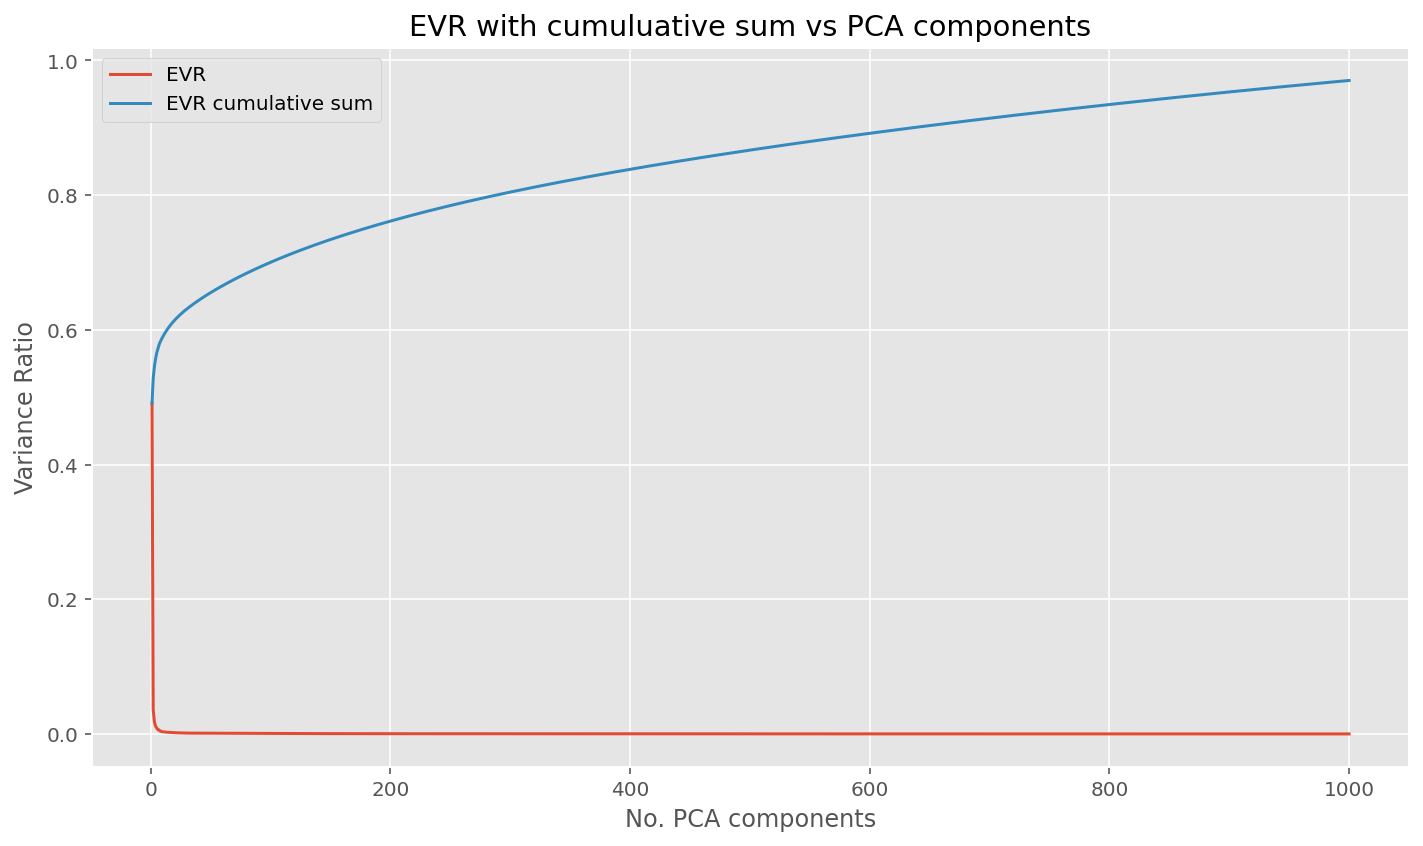

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.lineplot(x = range(1, pca.n_components_+1),y = pca.explained_variance_ratio_, ax=ax)
sns.lineplot(x = range(1, pca.n_components_+1),y = pca.explained_variance_ratio_.cumsum(), ax=ax)

#ax.set_xticklabels(labels = x, rotation = 30)  
ax.legend(labels=["EVR","EVR cumulative sum"])
ax.set_ylabel("Variance Ratio")
ax.set_xlabel("No. PCA components")
ax.set_title("EVR with cumuluative sum vs PCA components")
fig.tight_layout()
plt.show()

In [32]:
from scikitplot.decomposition import plot_pca_2d_projection

In [ ]:
plot_pca_2d_projection(pca, df_DB, df_DB.index, 
                       biplot=True,  
                       feature_labels=demo_noage.columns.to_list(), 
                       figsize=(12, 6))
plt.legend(loc=[1.1, 0], fontsize=8, ncol=3)
plt.show()